## Redes Neuronales Informadas por Física
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Trabajo Práctico Nº1

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Ezequiel Maudet       | eze.maudet@gmail.com      | a1812   |
| Federico Zoya         | fzoya33@gmail.com         | a1828   |

### Flow in a Square Cavity (Lid-Driven Cavity)

#### Description:

This is a standard test case to verify the accuracy of numerical methods solving the incompressible Navier-Stokes equations. The domain is $\Omega = [0,1] \times [0,1]$

Governing equations in steady state:

- Momentum equation (vector form): $(\mathbf{u} \cdot \nabla) \mathbf{u} = - \nabla p + \frac{1}{Re} \nabla^2 \mathbf{u}$ in $\Omega$

- Continuity equation (incompressibility): $\nabla \cdot \mathbf{u} = 0$ in $\Omega$

Boundary conditions:  

- No-slip condition on the side and bottom walls (velocity zero).
- Top wall moves at a constant velocity in the ( +x ) direction.

### 1. LIBRARIES AND GENERAL PARAMETERS

In [1]:
import scipy.io                     # for matlab files manipulation
import os                           # for files manipulation
import pandas as pd                 # for data manipulation
import numpy as np                  # for data manipulation
import matplotlib.pyplot as plt     # for plotting


import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
import random

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    # In general seed PyTorch operations
    torch.manual_seed(seed)

    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)

    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(seed)

    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True

    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

set_seed(42)

#### 2. PROBLEM DEFINITION

In [4]:
# Domain definition
x_min = 0
x_max = 1

y_min = 0
y_max = 1

In [5]:
# Velocity boundary conditions

U_bc = [0, 0, 0, 1]     # [left, right, bot, top]
V_bc = [0, 0, 0, 0]     # [left, right, bot, top]

### 3. GROUND TRUTH SOLUTION

We load the reference solution obtained by finite element analysis.

In [6]:
folder = 'Re-100'

# Read all files in folder
files = os.listdir(folder)

# Filter only MatLab files
mat_files = [f for f in files if f.endswith('.mat')]

print(mat_files)

['pressure.mat', 'velocity.mat']


In [7]:
def mat2df(mat_file):
    """
    Load a .mat file and convert its variables into a pandas DataFrame.
    
    Parameters:
    - mat_file: str, path to the .mat file
    
    Returns:
    - df: pandas.DataFrame with variables as columns
    """
    file_path = os.path.join(folder, mat_file)
    data = scipy.io.loadmat(file_path)
    variables = {}
    for key in data:
        if not key.startswith('__'):
            value = data[key]
            # Convert scalar values to list
            if np.isscalar(value):
                variables[key] = [value]
            elif isinstance(value, np.ndarray):
                # Flatten array if necessary
                if value.ndim == 1:
                    variables[key] = value
                else:
                    variables[key] = value.flatten()
    # Create DataFrame
    df = pd.DataFrame(variables)
    return df

In [8]:
df_pressure = mat2df(mat_files[0])
df_pressure.head(5)

,x,y,z,p
0,0.00,0.0,0.0,0.000000
1,0.01,0.0,0.0,0.000016
2,0.02,0.0,0.0,0.000013
3,0.03,0.0,0.0,-0.000038
4,0.04,0.0,0.0,-0.000131


In [9]:
df_velocity = mat2df(mat_files[1])
df_velocity.head(5)

,x,y,z,u,v,w
0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.01,0.0,0.0,0.0,0.0,0.0
2,0.02,0.0,0.0,0.0,0.0,0.0
3,0.03,0.0,0.0,0.0,0.0,0.0
4,0.04,0.0,0.0,0.0,0.0,0.0


In [10]:
df_fem = pd.merge(df_pressure[['x', 'y', 'p']], df_velocity[['x', 'y', 'u', 'v']], on=['x', 'y'], how='inner')
df_fem.head(5)

,x,y,p,u,v
0,0.00,0.0,0.000000,0.0,0.0
1,0.01,0.0,0.000016,0.0,0.0
2,0.02,0.0,0.000013,0.0,0.0
3,0.03,0.0,-0.000038,0.0,0.0
4,0.04,0.0,-0.000131,0.0,0.0


In [11]:
ndata = df_fem.shape[0]
ndata

20201

Contour plot for the FEM results:

In [95]:
from scipy.interpolate import griddata

def contourplot_df(df, coord_cols, value_col, levels=50):
    # Extract node coordinates and nodal values
    points = df[['x', 'y']].values
    values = df[value_col].values

    # Create grid for plotting
    grid_x, grid_y = np.mgrid[
        points[:,0].min():points[:,0].max():100j,
        points[:,1].min():points[:,1].max():100j
    ]

    # Interpolate nodal values onto grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Plot the contour
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='turbo')
    plt.colorbar(contour)
    plt.title(f'FEM results contour plot of {value_col}')
    plt.xlabel(coord_cols[0])
    plt.ylabel(coord_cols[1])
    plt.axis('equal')
    # plt.show()

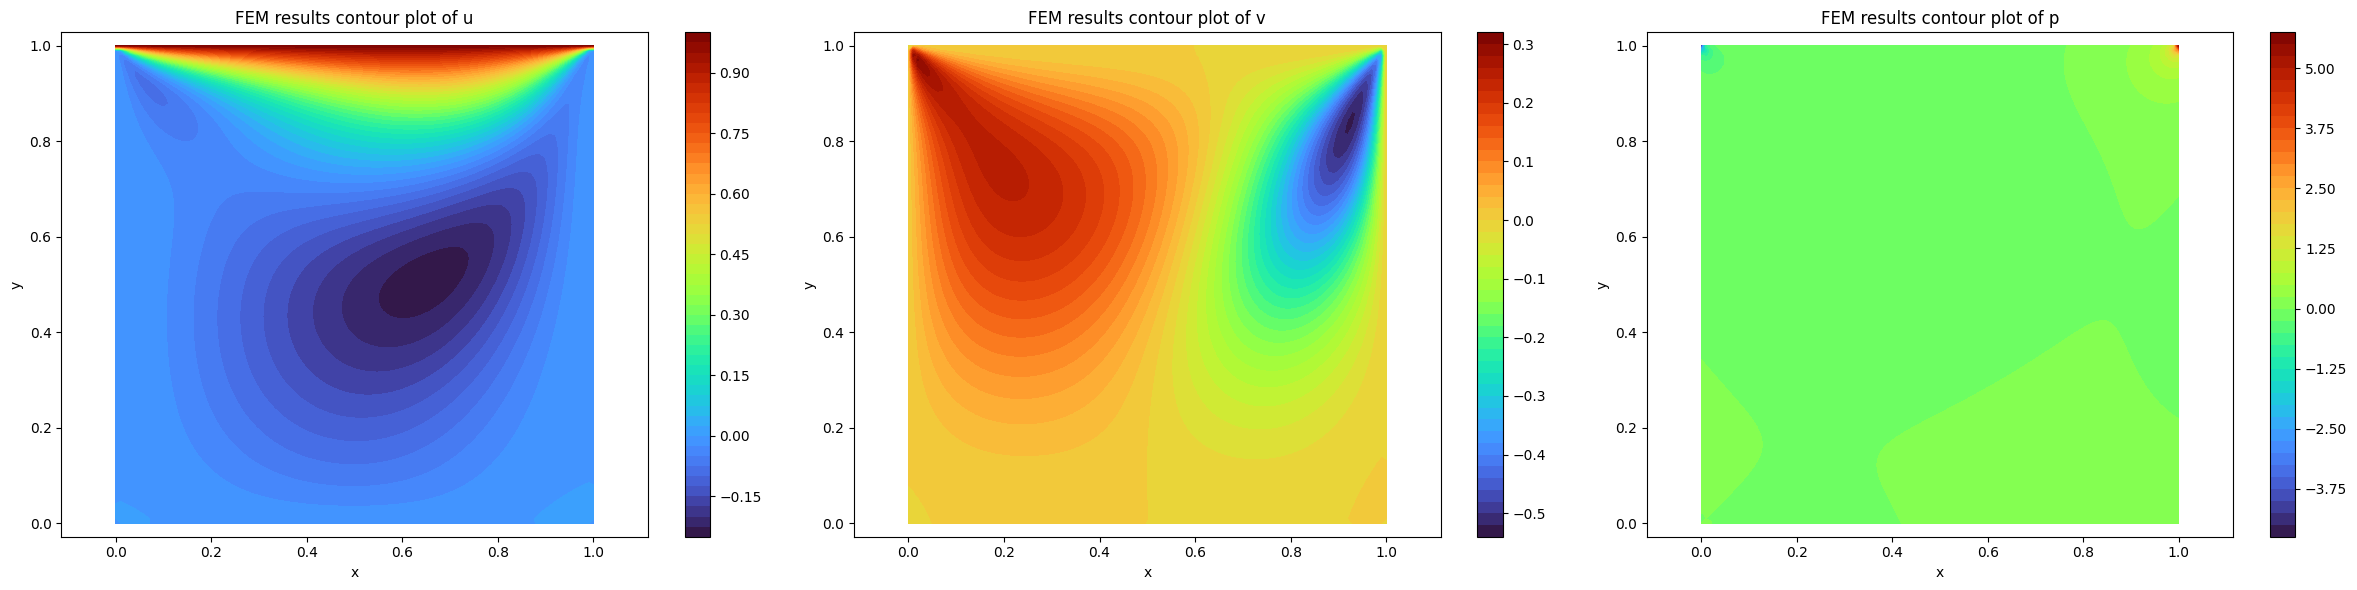

In [100]:
variables = ['u', 'v', 'p']
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, var in enumerate(variables):
    plt.sca(axes[i])
    contourplot_df(df_fem, ['x', 'y'], var)
    
for i, var in enumerate(variables):
    axes[i].set_title(f'FEM results contour plot of {var}')

plt.tight_layout()
plt.show()

### 4. DATA GENERATION

In [12]:
tags = ["Domain", "BoundaryConditions"]
isData = True          # Flag to indicate whether the analysis would use labelled data or not
nsamples = 10

# Initialize list of dataset objects
ds_uniform = []
ds_random = []

#### 4.1 Collocation points

We generate two sets of collocation points: one inside the domain where the PDE residual will be evaluated, and the other along the boundaries where conditions will be enforced.

We define an auxiliary function capable to generate both uniform and randomly distribuited collocation points.

In [13]:
def get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_out, random = True):
    """
    Generate collocation points for domain and boundary conditions.

    Args:
    - x_min, x_max: Minimum and maximum values for x-axis.
    - y_min, y_max: Minimum and maximum values for y-axis.
    - n_pde: Number of points for PDE domain.
    - n_bc: Number of points for each boundary.
    - random: Flag to choose between random and uniform distribution.
    - device: Device on which tensors should be allocated.

    Returns:
    - X_dom_tensor: Tensor containing the domain points.
    - X_bc_tensor: Tensor containing the boundary points.
    """
    if random:
        
        delta_x = x_max - x_min
        delta_y = y_max - y_min
        
        rand_aux = torch.rand((n_pde + 2 * n_bc, 2), device = device)
        
        x_dom = (x_min + delta_x * rand_aux[:n_pde, 0]).to(torch.float32)
        y_dom = (y_min + delta_y * rand_aux[:n_pde, 1]).to(torch.float32)
        
        y_left = (y_min + delta_y * rand_aux[n_pde:(n_pde + n_bc), 1]).to(torch.float32)
        y_right = (y_min + delta_y * rand_aux[-n_bc:, 1]).to(torch.float32)
    
        x_bot = (x_min + delta_x * rand_aux[n_pde:(n_pde + n_bc), 0]).to(torch.float32)
        x_top = (x_min + delta_x * rand_aux[-n_bc:, 0]).to(torch.float32)

    else:
        # Adjust n_pde for uniform case
        n_pde_sqrt = int(np.sqrt(n_pde))
        n_pde = n_pde_sqrt**2
        
        # Crear una cuadrícula 2D de tamaño n_pde x n_pde
        x_vals = torch.linspace(x_min, x_max, n_pde_sqrt, device=device)
        y_vals = torch.linspace(y_min, y_max, n_pde_sqrt, device=device)
        X_grid, Y_grid = torch.meshgrid(x_vals, y_vals, indexing='ij')

        # Aplanar las mallas en vectores 1D si quieres usar en los datos
        x_dom = X_grid.reshape(-1)
        y_dom = Y_grid.reshape(-1)    
        
        y_left = torch.linspace(y_min, y_max, n_bc, device = device)
        y_right = y_left.clone()
        
        x_bot = torch.linspace(x_min, x_max, n_bc, device = device)
        x_top = x_bot.clone()

    x_left = x_min * torch.ones(n_bc)
    x_right = x_max * torch.ones(n_bc)
    
    y_bot = y_min * torch.ones(n_bc)
    y_top = y_max * torch.ones(n_bc)

    # Combine all domain points
    X_dom_tensor = torch.stack((x_dom, y_dom), dim=1)

    # Combine all boundary points
    X_bc_tensor = torch.cat([
                torch.stack((x_left, y_left), dim=1),
                torch.stack((x_right, y_right), dim=1),
                torch.stack((x_bot, y_bot), dim=1),
                torch.stack((x_top, y_top), dim=1),
            ], axis=0)

    Y_dom_tensor = torch.zeros((n_pde, n_out), device=device)
    Y_bc_tensor = torch.zeros((4 * n_bc, n_out), device=device)
    print
    return X_dom_tensor, Y_dom_tensor, X_bc_tensor, Y_bc_tensor

In [14]:
from torch.utils.data import TensorDataset

# Number of collocation points
n_pde = 1_000       # for domain
n_bc = 100          # for Boundary conditions

X_dom_uniform_tensor, Y_dom_uniform_tensor, X_bc_uniform_tensor, Y_bc_uniform_tensor = get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_out = 3, random = False)
X_dom_rand_tensor, Y_dom_rand_tensor, X_bc_rand_tensor, Y_bc_rand_tensor= get_collocation_points(x_min, x_max, y_min, y_max, n_pde, n_bc, n_out = 3, random = True)

ds_uniform.append(TensorDataset(X_dom_uniform_tensor, Y_dom_uniform_tensor))
ds_uniform.append(TensorDataset(X_bc_uniform_tensor, Y_bc_uniform_tensor))

ds_random.append(TensorDataset(X_dom_rand_tensor, Y_dom_rand_tensor))
ds_random.append(TensorDataset(X_bc_rand_tensor, Y_bc_rand_tensor))


#### 4.2 Boundary Conditions

In [15]:
u_tensors = [ui * torch.ones((n_bc, 1)) for ui in U_bc]
v_tensors = [vi * torch.ones((n_bc, 1)) for vi in V_bc]

u_bc_tensor = torch.cat(u_tensors, axis=0)
v_bc_tensor = torch.cat(v_tensors, axis=0)

#### 4.3 Labelled data

In [16]:
if isData:
    tags.append("LabelledData")
    idx_data = np.random.choice(range(ndata), nsamples, replace=False)
    
    data_np = df_fem.iloc[idx_data].to_numpy()                      # Convert df to numpy
    data_tensor = torch.from_numpy(data_np).float().to(device)      # Convert numpy to torch tensor

    X_data = data_tensor[:, :2]     # columns (x, y)
    Y_data = data_tensor[:, 2:]     # columns (p, u, v)

    ds_uniform.append(TensorDataset(X_data, Y_data))
    ds_random.append(TensorDataset(X_data, Y_data))

#### 4.4 Plot grid

In [17]:
# Dictionary of dataset objects
datasets_uniform = dict(zip(tags, ds_uniform))
datasets_random = dict(zip(tags, ds_random))

In [18]:
def plot_grid(dataset, title = None):
    # Plot the locations of the collocation points in the space domain
    X_dom = (dataset["Domain"][:][0]).data.cpu().numpy()
    X_bc = (dataset["BoundaryConditions"][:][0]).data.cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_dom[:,0], X_dom[:, 1], s=4, c='r', label=f'N_dom={len(X_dom)}')
    ax.scatter(X_bc[:, 1:2], X_bc[:, 0:1], s=4, c='b', label=f'N_bc={len(X_bc)}')
    if isData:
        X_data = (dataset["LabelledData"][:][0]).data.cpu().numpy()
        ax.scatter(X_data[:, 0], X_data[:, 1], s=4, c='g', label=f'N_Data={len(X_data)}', marker='x')
    ax.legend()
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    if title is not None:
        plt.title(title)
    plt.show()

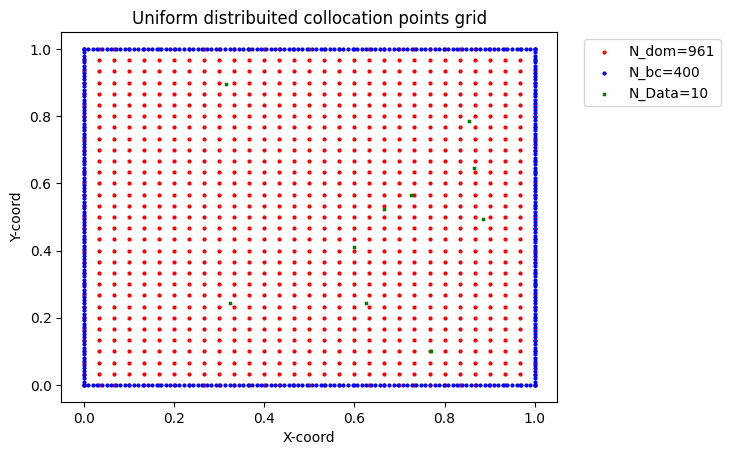

In [19]:
plot_grid(datasets_uniform, title='Uniform distribuited collocation points grid')

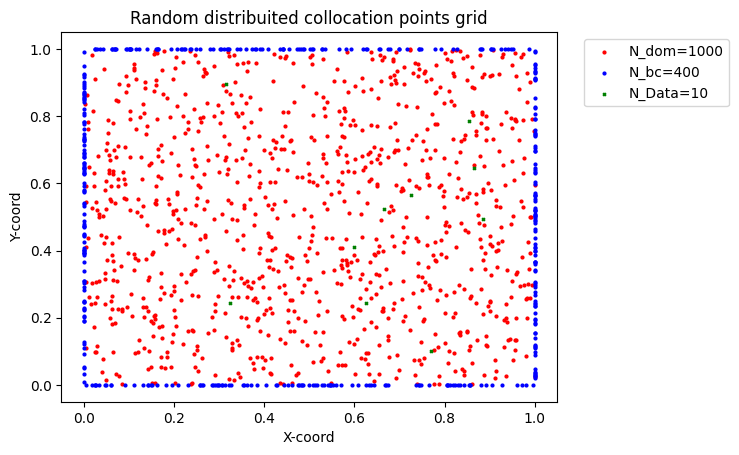

In [20]:
plot_grid(datasets_random, title='Random distribuited collocation points grid')

The sub-set defined inside the domain where the PDE will be solved shall include physical boundaries in order to enforce the physical governing equations in those regions. In parallel, another sub-set of boundary points shall be defined to impose the values of our prescribed boundary conditions. Furthermore, if our problem were time-dependent, a subset along the time coordinate shall also be established.